CUDA Convolutional Sparse Coding
================================

This example demonstrates the use of the interface to the CUDA CSC solver extension package, with a test for the availablity of a GPU that runs the Python version of the ConvBPDN solver if one is not available, or if the extension package is not installed.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import fft
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco import cuda
from sporco.admm import cbpdn


# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
sys_pipes = util.notebook_system_output()

Load example image.

In [2]:
img = util.ExampleImages().image('barbara.png', scaled=True, gray=True,
                                 idxexp=np.s_[10:522, 100:612])

Highpass filter example image.

In [3]:
npd = 16
fltlmbd = 20
sl, sh = signal.tikhonov_filter(img, fltlmbd, npd)

Load dictionary.

In [4]:
D = util.convdicts()['G:12x12x36']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [5]:
lmbda = 1e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False})

If GPU available, run CUDA ConvBPDN solver, otherwise run standard Python version.

In [6]:
if cuda.device_count() > 0:
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdn(D, sh, lmbda, opt)
    t = tm.elapsed()
else:
    print('GPU not found: running Python solver')
    c = cbpdn.ConvBPDN(D, sh, lmbda, opt)
    X = c.solve().squeeze()
    t = c.timer.elapsed('solve')
print('Solve time: %.2f s' % t)

GeForce RTX 2080 Ti GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     r         s         ρ
----------------------------------------------------------------
   0  6.26e+04  6.25e+04  1.02e+04  6.47e-01  7.54e-01  1.50e+00
   1  6.36e+04  6.35e+04  8.59e+03  3.36e-01  5.78e-01  1.50e+00
   2  7.68e+04  7.67e+04  1.04e+04  3.20e-01  3.53e-01  1.11e+00
   3  7.73e+04  7.72e+04  8.21e+03  2.50e-01  2.95e-01  1.11e+00
   4  7.40e+04  7.40e+04  7.18e+03  2.21e-01  1.95e-01  1.00e+00
   5  7.55e+04  7.55e+04  6.99e+03  1.65e-01  1.48e-01  1.00e+00
   6  7.99e+04  7.98e+04  6.64e+03  1.28e-01  1.33e-01  1.00e+00
   7  8.40e+04  8.39e+04  6.30e+03  1.06e-01  1.11e-01  1.00e+00
   8  8.48e+04  8.48e+04  6.08e+03  8.85e-02  9.98e-02  1.00e+00
   9  8.45e+04  8.45e+04  5.76e+03  7.54e-02  8.71e-02  1.00e+00
  10  8.47e+04  8.47e+04  5.54e+03  6.90e-02  7.52e-02  9.06e-01
  11  8.64e+04  8.63e+04  5.46e+03  5.92e-02  6.68e-02  9.06e-01
  12  8.81e+04  8.81e+04  5.38e+03  5.15e-02  6.08e-02  9.06e-01
  13  8.95e+04  8.95e+04  5.32e+

Reconstruct the image from the sparse representation.

In [7]:
shr = np.sum(fft.fftconv(D, X, axes=(0, 1)), axis=2)
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % metric.psnr(img, imgr))

Reconstruction PSNR: 44.12dB



Display representation and reconstructed image.

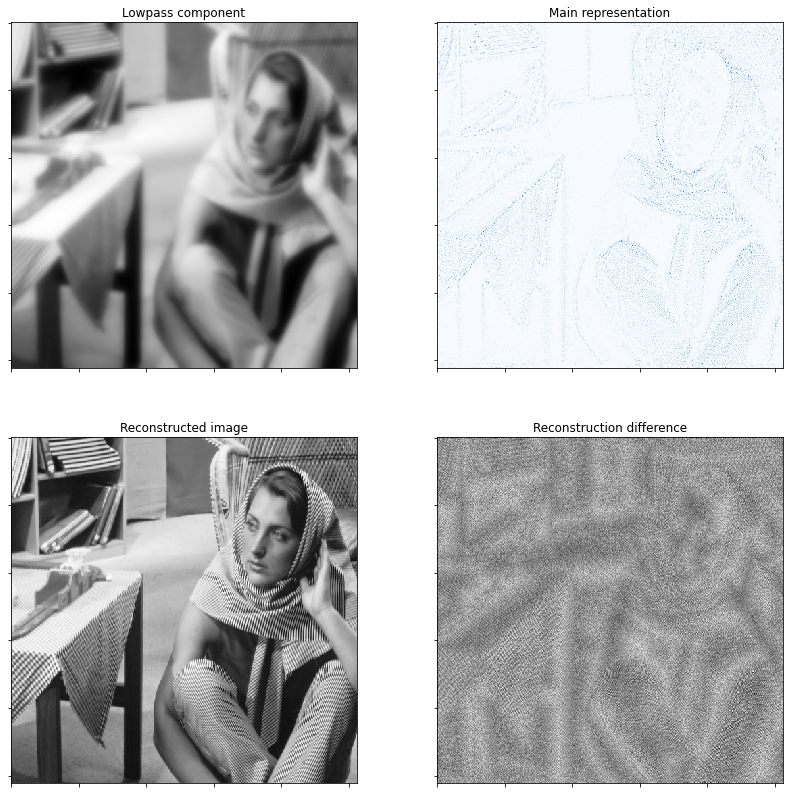

In [8]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sl, title='Lowpass component', fig=fig)
plot.subplot(2, 2, 2)
plot.imview(np.sum(abs(X), axis=2).squeeze(),
            cmap=plot.cm.Blues, title='Main representation', fig=fig)
plot.subplot(2, 2, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
plot.subplot(2, 2, 4)
plot.imview(imgr - img, fltscl=True, title='Reconstruction difference',
            fig=fig)
fig.show()